# Beta Pic

In [1]:
import eleanor
import pandas as pd
import os
os.chdir('../scripts')
from analysis_tools_cython import *

In [2]:
star = eleanor.Source(tic=270577175,sector=6)
data = eleanor.TargetData(star,height=15,width=15)

INFO: Found cached file /home/astro/phrdhx/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0006-3-3-cal-1686-0592_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0006-3-3-cal-1686-0592_tess_v2_bkg.fits with expected size 61162560. [astroquery.query]
INFO: Found cached file /home/astro/phrdhx/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0006-3-3-cal-1686-0592_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0006-3-3-cal-1686-0592_tess_v2_pc.fits with expected size 122411520. [astroquery.query]
INFO: Found cached file /home/astro/phrdhx/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0006-3-3-cal-1686-0592_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0006-3-3_tess_v2_pm.txt with expected size 185294. [astroquery.query]


In [3]:
q = data.quality == 0

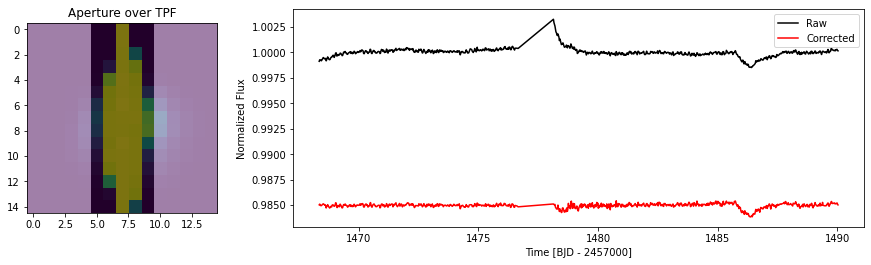

In [4]:
eleanor.TargetData.custom_aperture(data, shape='rectangle',h=15,w=5,pos=[7,7])
eleanor.TargetData.get_lightcurve(data)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,3]})
ax1.imshow(data.tpf[0])
ax1.imshow(data.aperture, cmap='Greys', alpha=0.5)
ax1.set_title('Aperture over TPF')
#plt.imshow(data.aperture)

ax2.plot(data.time[q], data.raw_flux[q]/np.nanmedian(data.raw_flux[q]), 'k', label='Raw')
ax2.plot(data.time[q], data.corr_flux[q]/np.nanmedian(data.corr_flux[q]) - 0.015, 'r', label='Corrected')
ax2.legend()
ax2.set_xlabel('Time [BJD - 2457000]')
ax2.set_ylabel('Normalized Flux');

---
## Finding nearby stars to the target

In [5]:
nearby = [270577175,27057440, 270577169, 270577170, 270577168]

In [6]:
fluxes = [] 
quality = []
for i in nearby:
    print(i)
    try:
        star = eleanor.Source(tic=i, sector=6)
        data = eleanor.TargetData(star,height=15,width=15)
        eleanor.TargetData.custom_aperture(data, shape='rectangle',h=15,w=4,pos=[7,7])
        eleanor.TargetData.get_lightcurve(data)
        q = data.quality == 0
        flux = data.corr_flux
        fluxes.append(np.array(flux)/np.nanmedian(flux))
        #quality.append(q)
    except:
        print(f"TIC {i} not downloaded, moving on.")
        continue
fluxes = np.array(fluxes)

270577175
INFO: Found cached file /home/astro/phrdhx/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0006-3-3-cal-1686-0592_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0006-3-3-cal-1686-0592_tess_v2_bkg.fits with expected size 61162560. [astroquery.query]
INFO: Found cached file /home/astro/phrdhx/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0006-3-3-cal-1686-0592_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0006-3-3-cal-1686-0592_tess_v2_pc.fits with expected size 122411520. [astroquery.query]
INFO: Found cached file /home/astro/phrdhx/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0006-3-3-cal-1686-0592_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0006-3-3_tess_v2_pm.txt with expected size 185294. [astroquery.query]
27057440
TIC 27057440 not downloaded, moving on.
270577169
INFO: Found cached file /home/astro/phrdhx/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0006-3-3-cal-1686-0646_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0006-3-3-cal-

In [7]:
fluxes.shape

(4, 993)

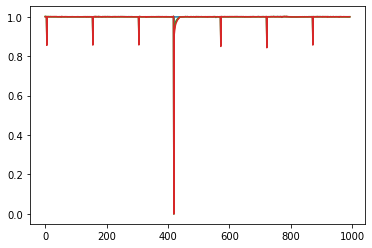

In [8]:
plt.plot(fluxes.T)

In [9]:
from sklearn.decomposition import PCA

In [10]:
pca = PCA(n_components=3)
commons = pca.fit(fluxes.T)
transform = pca.transform(fluxes.T)

transform.shape

(993, 3)

(-0.003, 0.0023)

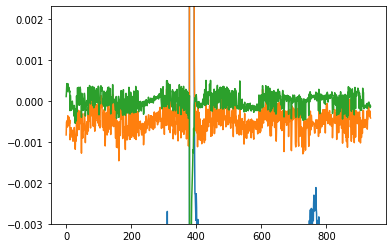

In [11]:
plt.plot(transform[:,][q])
plt.ylim([-0.003,0.0023])

In [12]:
pca.explained_variance_ratio_

array([9.95411747e-01, 4.31663459e-03, 2.48399234e-04])

In [13]:
A = transform#[:,0:3]
f = fluxes[0]
ATA = np.dot(A.T, A)
invATA  = np.linalg.inv(ATA)
A_coeff = np.dot(invATA, A.T)
weights = np.dot(A_coeff, f) ## same as xhat

In [14]:
bpic_raw_flux = data.raw_flux
bpic_flux = data.corr_flux

(0.994, 1.003)

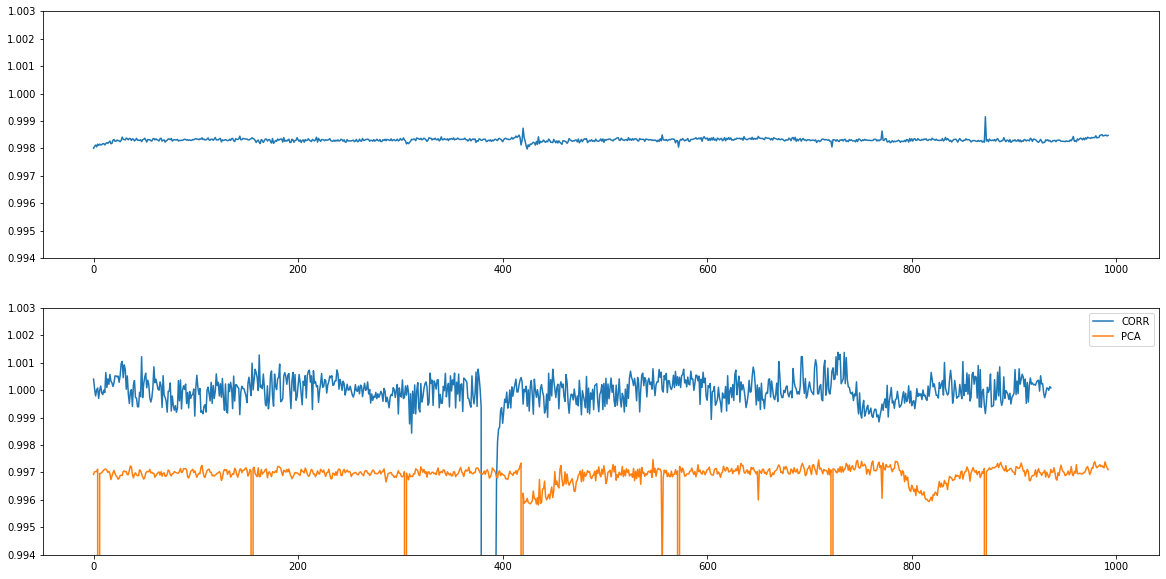

In [82]:
science = f - np.dot(A, weights)
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharey=True,figsize=(20,10))
ax1.plot(science)
#ax2.plot(bpic_raw_flux[q]/np.nanmedian(bpic_raw_flux[q])+0.001, label= 'RAW')
ax2.plot(bpic_flux[q]/np.nanmedian(bpic_flux[q]),label = 'CORR')
ax2.plot(f-0.003,label='PCA')
ax2.legend()
ax2.set_ylim([0.994,1.003])

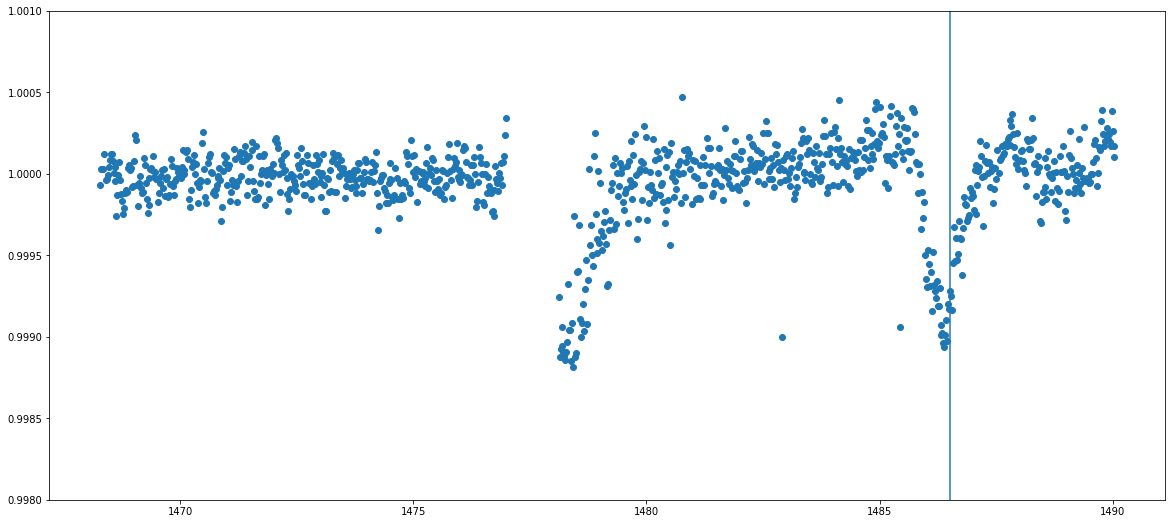

In [83]:
plt.figure(figsize=(20,9))
plt.scatter(data.time,f)
plt.ylim([0.998,1.001])
plt.axvline(1486.5)

In [612]:
lc = pd.DataFrame(data=[data.time,f*np.nanmedian(data.corr_flux),data.quality,data.flux_err]).T
cols = ['TIME','PCA_FLUX','QUALITY','FLUX_ERR']
lc.columns = cols
indices = lc.loc[(lc['TIME'] >= 1486.0) & (lc['TIME'] <= 1486.2)].index

# Change the corresponding 'flux' values to 1

ind = [771,756,759,864,867,868,857,847,850,851]
lc.loc[ind, 'PCA_FLUX'] = np.nanmedian(lc['PCA_FLUX'])
lc.loc[835,'PCA_FLUX'] = 2.671070e+06
lc.loc[825,'PCA_FLUX'] = 2.670669e+06
lc.loc[804,'PCA_FLUX'] = 2.670520e+06
lc.loc[[775,785,786],'PCA_FLUX'] = 2.672692e+06
lc.loc[812,'PCA_FLUX'] = 2.669558e+06
lc.loc[722,'PCA_FLUX'] = 2.672485e+06
lc.loc[800,'PCA_FLUX'] = 2.670148e+06


In [613]:
lc.loc[indices, 'PCA_FLUX']

799    2.670285e+06
800    2.670148e+06
801    2.670648e+06
802    2.670296e+06
803    2.670523e+06
804    2.670520e+06
805    2.670848e+06
806    2.670310e+06
807    2.670219e+06
808    2.670104e+06
Name: PCA_FLUX, dtype: float64

In [614]:
q = lc.QUALITY == 0

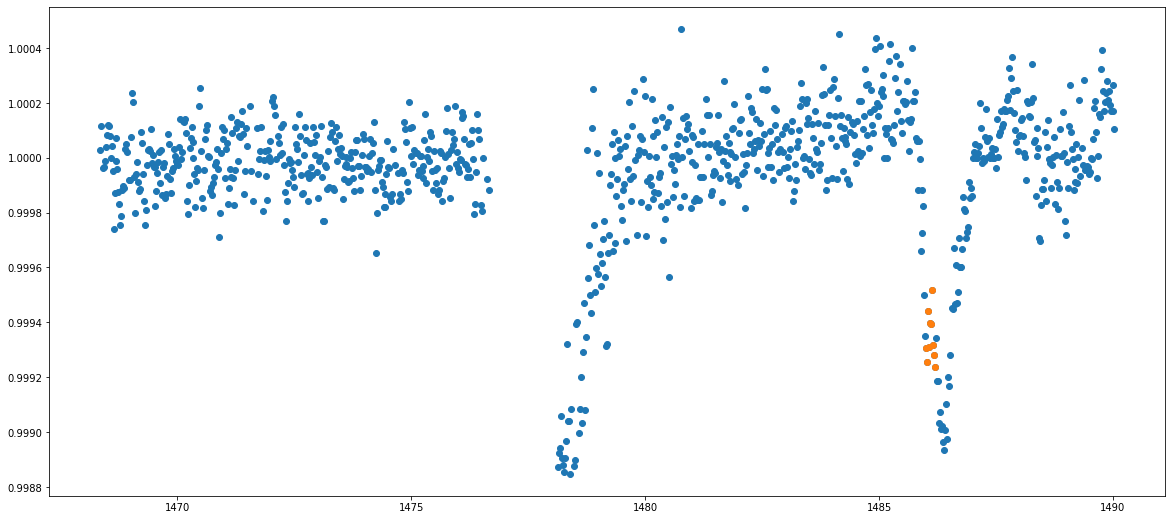

In [615]:
plt.figure(figsize=(20,9))
#plt.scatter(data.time,f)
plt.scatter(lc['TIME'][q],(lc['PCA_FLUX']/np.median(lc['PCA_FLUX']))[q])
plt.scatter(lc['TIME'][indices],(lc['PCA_FLUX']/np.median(lc['PCA_FLUX']))[indices])
#plt.ylim([0.998,1.001])

In [616]:
lc = Table.from_pandas(lc)

In [617]:
from astropy.io import fits

In [618]:
hdul = fits.open('../hlsp_gsfc-eleanor-lite_tess_ffi_s0006-0000000270577175_tess_v1.0_lc.fits')

In [619]:
for i, col_name in enumerate(lc.columns):
    hdul[1].data[col_name] = lc[col_name]

In [679]:
test,lc_info = import_lightcurve('/storage/astro2/phsqzm/TESS/SPOC_30min/S06/target/0000/0002/7057/7175/hlsp_tess-spoc_tess_phot_0000000270577175-s0006_tess_v1_lc.fits',pipeline='spoc')

In [621]:
lc = mad_cuts(lc,info=lc_info,clip=3)

In [622]:
qual = lc['QUALITY'] == 0

In [623]:
lc = lc[qual]

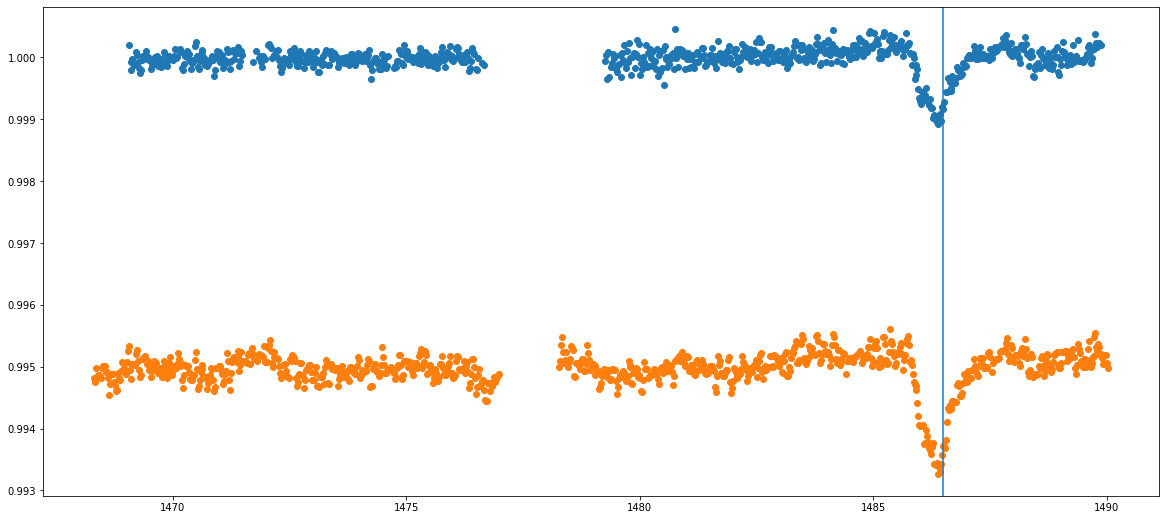

In [624]:
plt.figure(figsize=(20,9))
plt.scatter(lc['TIME'],lc['PCA_FLUX']/np.median(lc['PCA_FLUX']))
plt.scatter(test['TIME'],test['PDCSAP_FLUX']/np.median(test['PDCSAP_FLUX'])-0.005)
plt.axvline(1486.5)


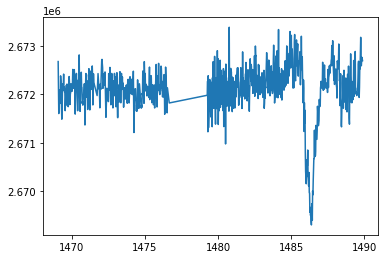

In [625]:
plt.plot(lc['TIME'],lc['PCA_FLUX'])

In [626]:
lc = Table.from_pandas(lc)

AttributeError: 'Column' object has no attribute 'isnull'

In [680]:
results, _ = processing(test,lc_info=lc_info,method='median')

In [683]:
results = results.split()

In [684]:
import pickle

with open('betapic.pkl', 'wb') as file:
    pickle.dump(results, file)

In [629]:
import lightkurve as lk

In [652]:
search = lk.search_lightcurve('Beta Pictoris',sector=6)
qlp = search[2].download()

In [653]:
qlp = qlp.to_table()

In [654]:
qlp = qlp['time','sap_flux','quality','flux_err']

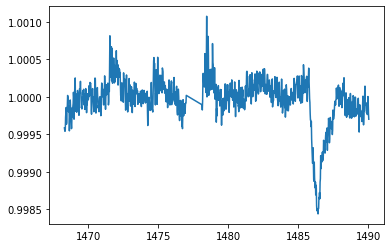

In [656]:
plt.plot(qlp['time'].value,qlp['sap_flux'])

In [659]:
qlp['sap_flux'] = qlp['sap_flux'] * np.median(lc['PCA_FLUX'])

In [664]:
qlp = qlp.to_pandas()

AttributeError: 'DataFrame' object has no attribute 'to_pandas'

In [666]:
qlp = Table.from_pandas(qlp)

In [667]:
processing(qlp,lc_info=lc_info,method='median')

ValueError: setting an array element with a sequence.

In [674]:
test, _ = import_lightcurve('../hlsp_gsfc-eleanor-lite_tess_ffi_s0006-0000000270577175_tess_v1.0_lc.fits')

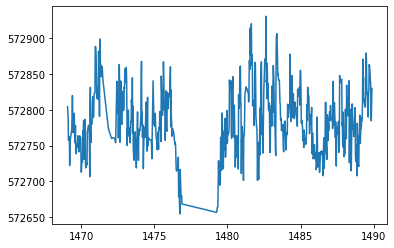

In [676]:
plt.plot(test['TIME'],test['CORR_FLUX'])

In [673]:
test

(<Table length=783>
        TIME        CORR_FLUX QUALITY ... Y_CENTROID  PCA_FLUX  RAW_FLUX
      float64        float32   int32  ...  float32    float32   float32 
 ------------------ --------- ------- ... ---------- --------- ---------
 1469.0541466588459 572804.44       0 ...   76.87874  572797.6 572823.56
 1469.0958132780145 572788.75       0 ...   76.88377  572747.5  572764.6
 1469.1166465894519  572757.4       0 ...    76.8747 572755.06  572749.0
 1469.1374799019623 572759.75       0 ...  76.893364  572730.0 572726.75
 1469.1791465295832  572762.1       0 ...   76.87889  572711.6 572713.25
 1469.1999798443387 572722.06       0 ...   76.88777 572712.56 572675.06
 1469.2208131594641  572749.0       0 ...  76.872314 572785.44 572705.75
 1469.2416464747494 572755.06       0 ...    76.8778  572800.4 572721.25
 1469.2624797899784  572761.1       0 ...   76.87943  572735.0  572698.4
  1469.304146419402 572766.75       0 ...   76.86598  572644.4 572606.25
                ...       ...  